In [1]:
# Importing Libraries
import os
import requests
import json
from typing import List
from dotenv import load_dotenv
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
from IPython.display import display, Markdown

In [2]:
from openai import OpenAI

load_dotenv(override=True)
api_key = os.getenv('OPENAI_API_KEY')
if api_key and api_key.startswith('sk-proj-') and len(api_key)>10:
    print("API key looks good so far")
else:
    print("There might be a problem with your API key? Please visit the troubleshooting notebook!")
    
MODEL = 'gpt-4o-mini'
openai = OpenAI(api_key=api_key)  # Pass the API key here

API key looks good so far


In [7]:
class CSVSummarizer:
    def __init__(self):
        self.client = openai
    
    def load_csv(self, file_path, **kwargs):
        """Load CSV file with appropriate options"""
        # Default parameters for read_csv
        params = {
            'sep': ',',  # Default separator
            'header': 0,  # First row as header
            'encoding': 'utf-8',
            'low_memory': False  # Better for mixed data types
        }
        # Update with any user-provided parameters
        params.update(kwargs)
        
        try:
            df = pd.read_csv(file_path, **params)
            print(f"CSV loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
            return df
        except Exception as e:
            print(f"Error loading CSV: {str(e)}")
            # Try again with different encoding if it fails
            if 'encoding' not in kwargs:
                try:
                    print("Trying with different encoding...")
                    df = pd.read_csv(file_path, encoding='latin1', **{k:v for k,v in params.items() if k != 'encoding'})
                    print(f"CSV loaded successfully with latin1 encoding: {df.shape[0]} rows, {df.shape[1]} columns")
                    return df
                except:
                    pass
            return None
    
    def analyze_dataframe(self, df):
        """Extract key statistics and insights from the DataFrame"""
        analysis = {
            "shape": df.shape,
            "columns": list(df.columns),
            "dtypes": {col: str(dtype) for col, dtype in df.dtypes.items()},
            "missing_values": df.isnull().sum().to_dict(),
        }
        
        # Add statistics for numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            analysis["numeric_stats"] = {}
            for col in numeric_cols:
                analysis["numeric_stats"][col] = {
                    "min": float(df[col].min()) if not pd.isna(df[col].min()) else None,
                    "max": float(df[col].max()) if not pd.isna(df[col].max()) else None,
                    "mean": float(df[col].mean()) if not pd.isna(df[col].mean()) else None,
                    "median": float(df[col].median()) if not pd.isna(df[col].median()) else None,
                    "std": float(df[col].std()) if not pd.isna(df[col].std()) else None
                }
        
        # Add statistics for categorical columns
        cat_cols = df.select_dtypes(include=['object']).columns
        if len(cat_cols) > 0:
            analysis["categorical_stats"] = {}
            for col in cat_cols:
                value_counts = df[col].value_counts()
                analysis["categorical_stats"][col] = {
                    "unique_count": int(df[col].nunique()),
                    "top_values": value_counts.head(5).to_dict() if len(value_counts) > 0 else {}
                }
        
        # Add correlations if applicable
        if len(numeric_cols) > 1:
            # Calculate correlations safely
            corr_matrix = df[numeric_cols].corr()
            # Convert to dictionary and handle NaN values
            corr_dict = {}
            for col1 in corr_matrix.columns:
                corr_dict[col1] = {}
                for col2 in corr_matrix.columns:
                    val = corr_matrix.loc[col1, col2]
                    corr_dict[col1][col2] = float(val) if not pd.isna(val) else 0
            analysis["correlation"] = corr_dict
            
        return analysis
    
    def create_prompt(self, df, analysis, focus=None):
        """Create a prompt for GPT-4o-mini based on the data analysis"""
        prompt = f"""Analyze this CSV dataset with {df.shape[0]} rows and {df.shape[1]} columns.

Column information:
"""
        # Add column details
        for col in df.columns:
            col_type = df[col].dtype
            missing = df[col].isnull().sum()
            missing_pct = (missing / len(df)) * 100
            
            prompt += f"- {col} ({col_type}): "
            if np.issubdtype(col_type, np.number):
                if not df[col].empty and not df[col].isnull().all():
                    prompt += f"range {df[col].min():.2f} to {df[col].max():.2f}, mean {df[col].mean():.2f}"
                else:
                    prompt += "all null values"
            else:
                prompt += f"{df[col].nunique()} unique values"
                if df[col].nunique() <= 5:
                    top_vals = df[col].value_counts().head(5).to_dict()
                    vals_str = ", ".join([f"{k} ({v})" for k, v in top_vals.items()])
                    prompt += f" [{vals_str}]"
                
            if missing > 0:
                prompt += f", {missing_pct:.1f}% missing"
            prompt += "\n"
            
        # Add statistical insights for numerical columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            prompt += "\nKey statistics for numerical columns:\n"
            for col in numeric_cols[:5]:  # Limit to first 5 columns
                if not df[col].empty and not df[col].isnull().all():
                    prompt += f"- {col}: min={df[col].min():.2f}, max={df[col].max():.2f}, "
                    prompt += f"mean={df[col].mean():.2f}, median={df[col].median():.2f}, std={df[col].std():.2f}\n"
                
        # Add correlation insights
        if len(numeric_cols) > 1:
            corr = df[numeric_cols].corr().fillna(0)  # Fill NaN with 0 for safety
            prompt += "\nNotable correlations:\n"
            
            # Get top correlations
            corr_pairs = []
            for i in range(len(numeric_cols)):
                for j in range(i+1, len(numeric_cols)):
                    corr_value = corr.iloc[i, j]
                    if abs(corr_value) > 0.5:  # Threshold for "notable" correlations
                        corr_pairs.append((numeric_cols[i], numeric_cols[j], corr_value))
            
            # Sort by absolute correlation value
            corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
            
            # Add top correlations to prompt
            for col1, col2, corr_value in corr_pairs[:5]:  # Limit to top 5
                prompt += f"- {col1} and {col2}: {corr_value:.2f}\n"
        
        # Add sample data (first few rows)
        sample_data = df.head(5).to_string()
        if len(sample_data) < 1500:  # Make sure we don't exceed token limits
            prompt += f"\nSample data (first 5 rows):\n{sample_data}\n"
        else:
            prompt += f"\nSample data snapshot (too large to show all columns):\n{df.head(5).iloc[:, :5].to_string()}\n"
        
        # Add focus if specified
        if focus:
            prompt += f"\nPlease focus your analysis specifically on: {focus}\n"
            
        # Add instructions for the model
        prompt += """
Based on this CSV data, please provide:
1. A comprehensive yet concise summary (3-4 paragraphs)
2. Key insights and findings
3. Data quality issues or limitations
4. Recommendations for further analysis

Format the response in Markdown with appropriate headers and bullet points.
"""
        return prompt
    
    def summarize(self, df, focus=None):
        """Generate a summary of the CSV data using GPT-4o-mini"""
        # Analyze dataframe
        analysis = self.analyze_dataframe(df)
        
        # Create prompt
        prompt = self.create_prompt(df, analysis, focus)
        
        # Call GPT-4o-mini
        try:
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a data analyst specializing in CSV data analysis."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=1000,
                temperature=0.3
            )
            
            summary = response.choices[0].message.content
            return Markdown(summary)
            
        except Exception as e:
            return f"Error generating summary: {str(e)}"
    
    def visualize_data(self, df):
        """Generate visualizations for the DataFrame"""
        # Basic info
        print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
        
        # Data types
        print("\nData Types:")
        dtype_counts = df.dtypes.value_counts().to_dict()
        for dtype, count in dtype_counts.items():
            print(f"- {dtype}: {count} columns")
        
        # Missing values plot
        missing = df.isnull().sum()
        if missing.sum() > 0:
            plt.figure(figsize=(10, 6))
            missing_sorted = missing[missing > 0].sort_values(ascending=False)
            if len(missing_sorted) > 15:  # If too many columns with missing values
                missing_sorted = missing_sorted.head(15)  # Show top 15
            missing_sorted.plot(kind='bar')
            plt.title('Missing Values by Column (Top 15)')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()
            
            # Missing values percentage
            print(f"\nTotal missing values: {missing.sum()} ({missing.sum()/(df.size)*100:.2f}% of all data)")
        
        # Numerical distributions
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            cols_to_plot = numeric_cols[:min(5, len(numeric_cols))]  # Limit to 5 columns
            if len(cols_to_plot) > 0:
                print("\nNumerical Distributions:")
                fig, axes = plt.subplots(len(cols_to_plot), 2, figsize=(15, 4*len(cols_to_plot)))
                if len(cols_to_plot) == 1:  # If only one column, axes needs to be 2D
                    axes = np.array([axes])
                    
                for i, col in enumerate(cols_to_plot):
                    # Skip if all values are missing
                    if df[col].isnull().all():
                        continue
                        
                    # Histogram
                    sns.histplot(df[col].dropna(), kde=True, ax=axes[i, 0])
                    axes[i, 0].set_title(f'Distribution of {col}')
                    
                    # Boxplot
                    sns.boxplot(x=df[col].dropna(), ax=axes[i, 1])
                    axes[i, 1].set_title(f'Boxplot of {col}')
                
                plt.tight_layout()
                plt.show()
            
        # Correlation heatmap
        if len(numeric_cols) > 1:
            print("\nCorrelation Analysis:")
            # Select columns for correlation analysis (limit to prevent too large heatmaps)
            if len(numeric_cols) > 10:
                print("Note: Showing correlation for first 10 numeric columns only")
                corr_cols = numeric_cols[:10]
            else:
                corr_cols = numeric_cols
                
            corr = df[corr_cols].corr()
            
            plt.figure(figsize=(10, 8))
            mask = np.triu(np.ones_like(corr, dtype=bool))  # Mask for upper triangle
            sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
                      vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
            plt.title('Correlation Heatmap')
            plt.tight_layout()
            plt.show()
            
        # Categorical data visualization
        cat_cols = df.select_dtypes(include=['object']).columns
        if len(cat_cols) > 0:
            cols_to_plot = cat_cols[:min(3, len(cat_cols))]  # Limit to 3 columns
            if len(cols_to_plot) > 0:
                print("\nCategorical Data Distribution:")
                plt.figure(figsize=(15, 5*len(cols_to_plot)))
                
                for i, col in enumerate(cols_to_plot):
                    plt.subplot(len(cols_to_plot), 1, i+1)
                    
                    # If too many unique values, just show top ones
                    if df[col].nunique() > 10:
                        value_counts = df[col].value_counts().head(10)
                        plt.title(f'Top 10 values in {col} (out of {df[col].nunique()} unique values)')
                    else:
                        value_counts = df[col].value_counts()
                        plt.title(f'Values in {col}')
                        
                    sns.barplot(x=value_counts.index, y=value_counts.values)
                    plt.xticks(rotation=45, ha='right')
                
                plt.tight_layout()
                plt.show()
    
    def analyze_csv(self, file_path, focus=None, **csv_params):
        """Complete analysis workflow for a CSV file"""
        # Load data
        df = self.load_csv(file_path, **csv_params)
        if df is None:
            return None, None
        
        # Basic info about the data
        print("\nQuick Data Overview:")
        display(df.head())
        
        # Generate visualizations
        print("\nData Visualizations:")
        self.visualize_data(df)
        
        # Generate summary
        print("\nGenerating GPT-4o-mini Analysis...")
        summary = self.summarize(df, focus)
        display(summary)
        
        return df, summary

CSV loaded successfully: 10000 rows, 11 columns

Quick Data Overview:


,Car_ID,Brand,Model,Year,Fuel_Type,Transmission,Price,Mileage,Engine_CC,Seating_Capacity,Service_Cost
0,1,Toyota,Innova,2024,CNG,Manual,2020000.0,27.3,800,4,24100.0
1,2,Kia,EV6,2023,Diesel,Manual,1770000.0,16.4,2500,7,18800.0
2,3,Maruti Suzuki,Dzire,2016,Petrol,Manual,3430000.0,17.6,2000,6,24700.0
3,4,Honda,Amaze,2019,Petrol,Manual,1610000.0,19.2,2500,6,23300.0
4,5,Honda,City,2015,Electric,Manual,1840000.0,15.8,1000,5,5800.0



Data Visualizations:
Dataset Shape: 10000 rows × 11 columns

Data Types:
- int64: 4 columns
- object: 4 columns
- float64: 3 columns

Numerical Distributions:


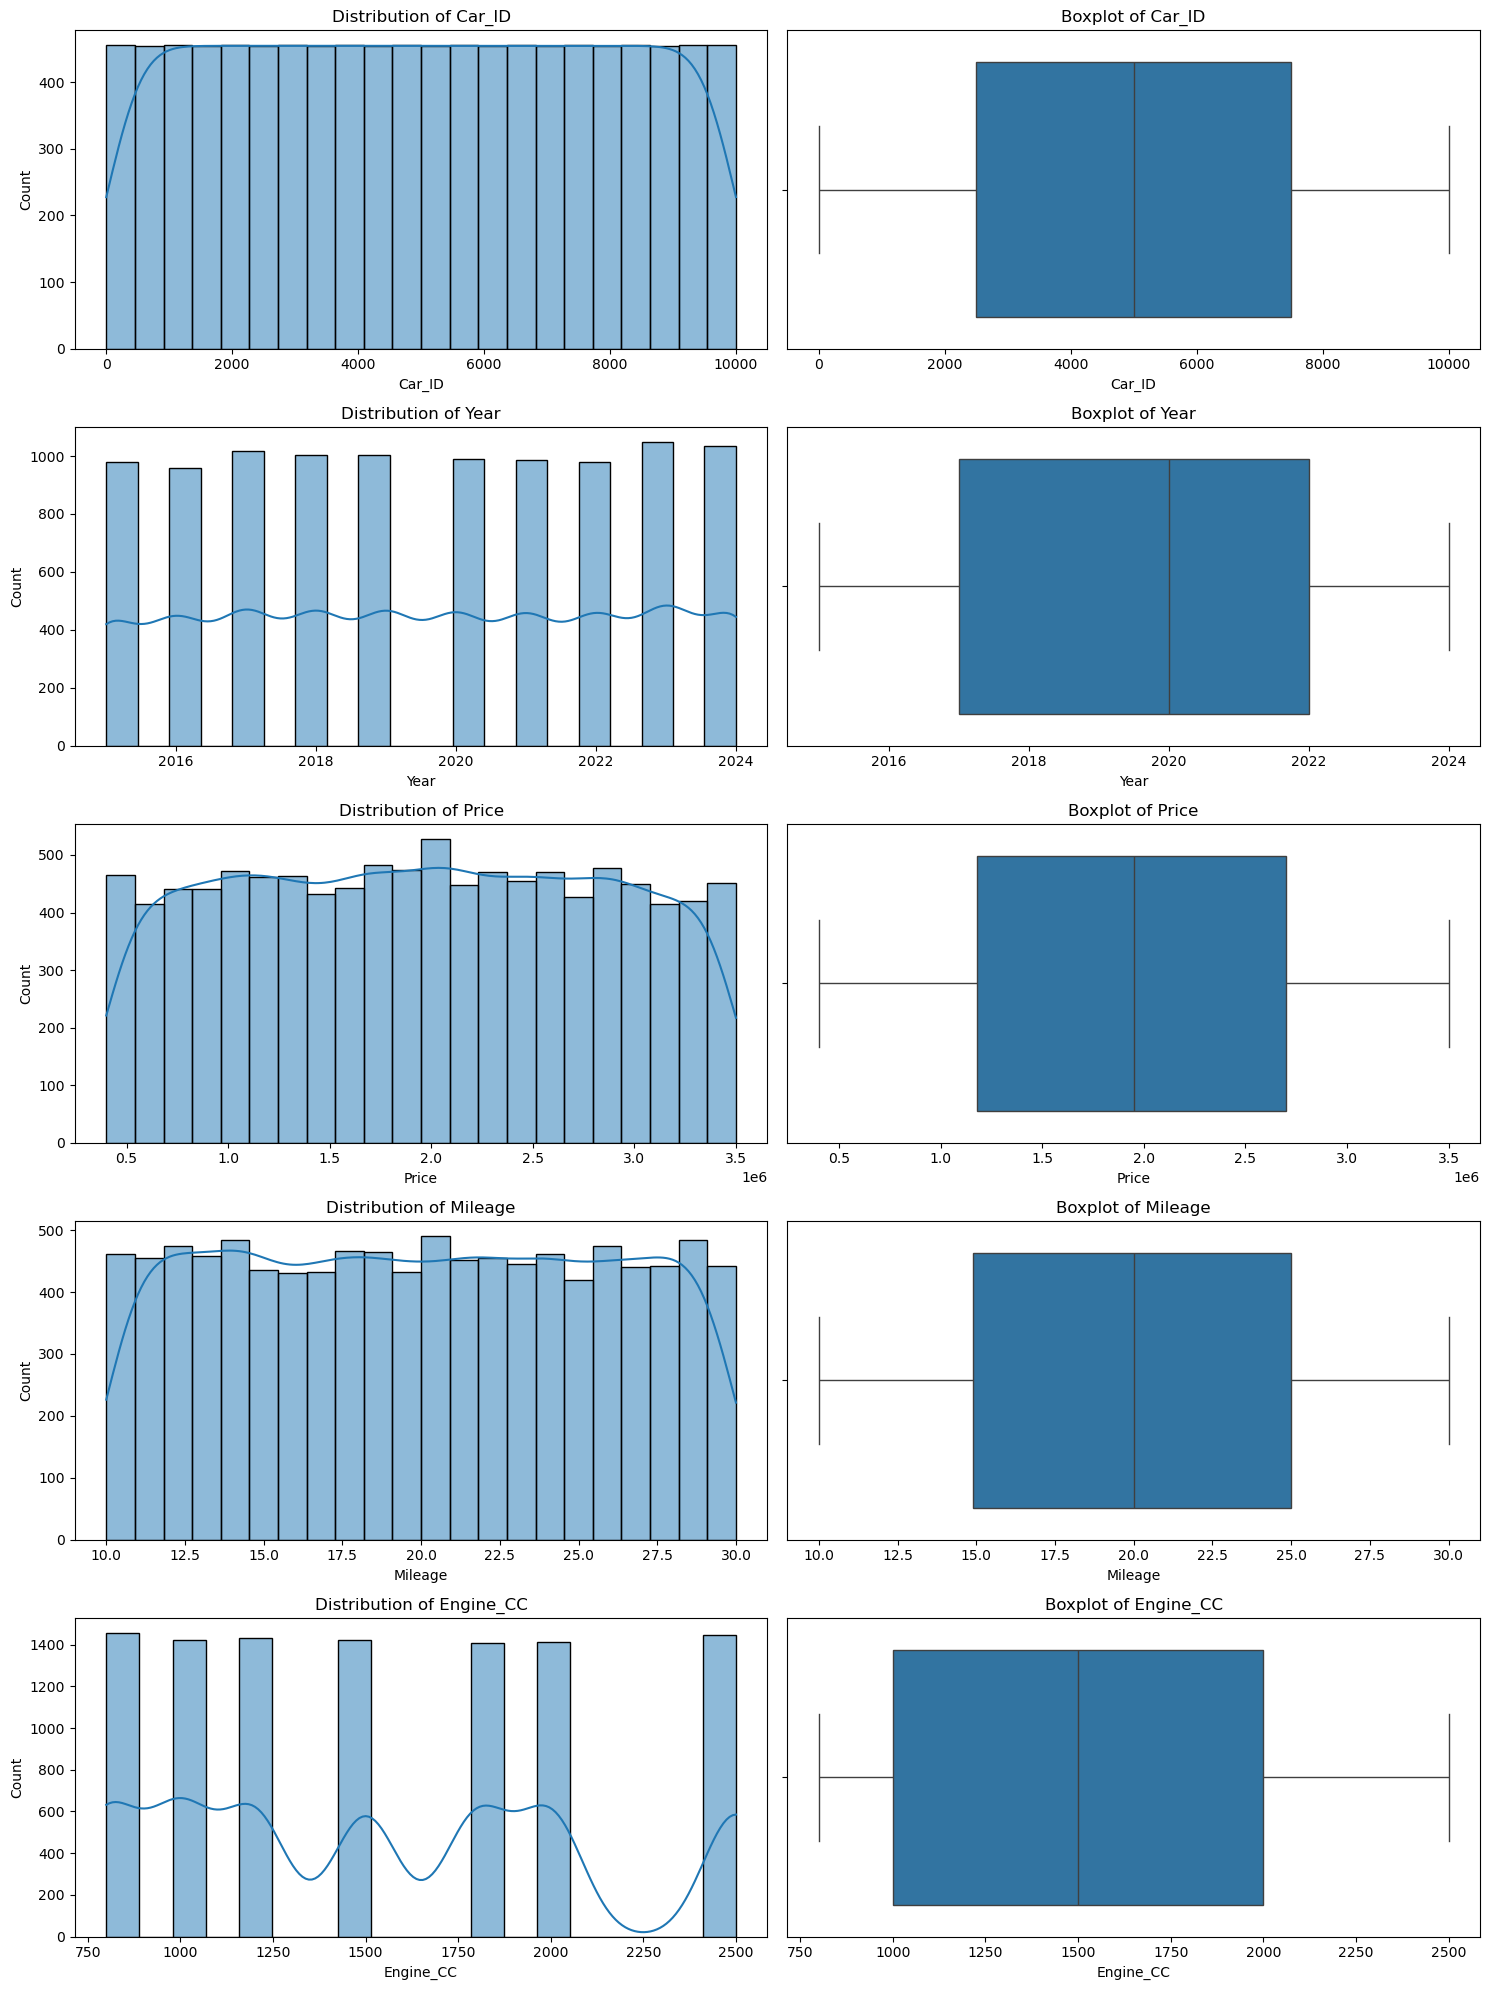


Correlation Analysis:


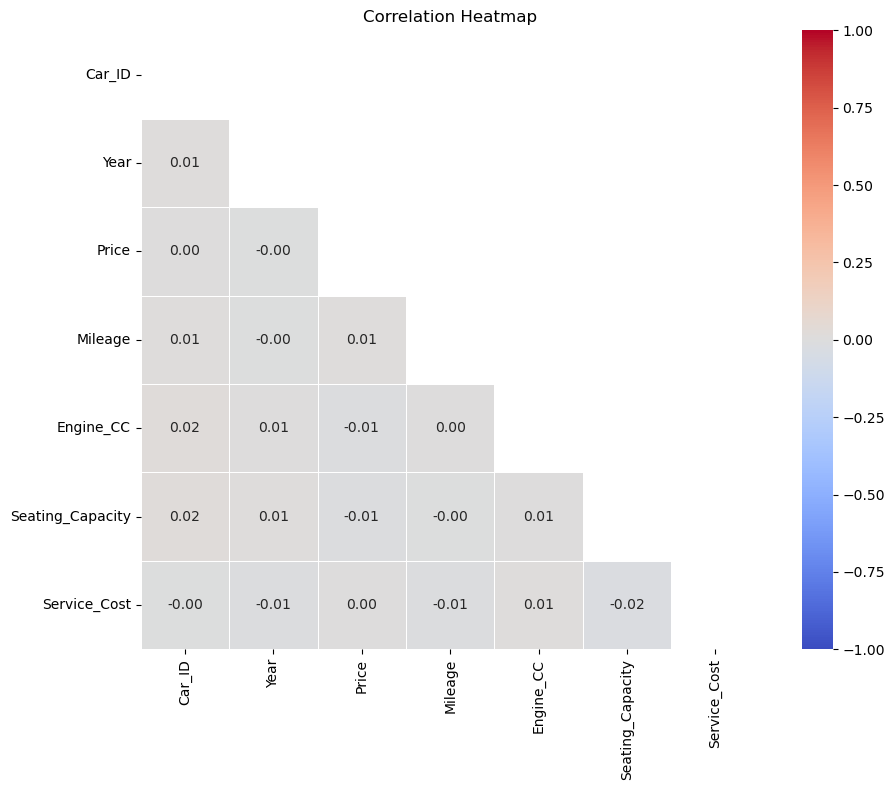


Categorical Data Distribution:


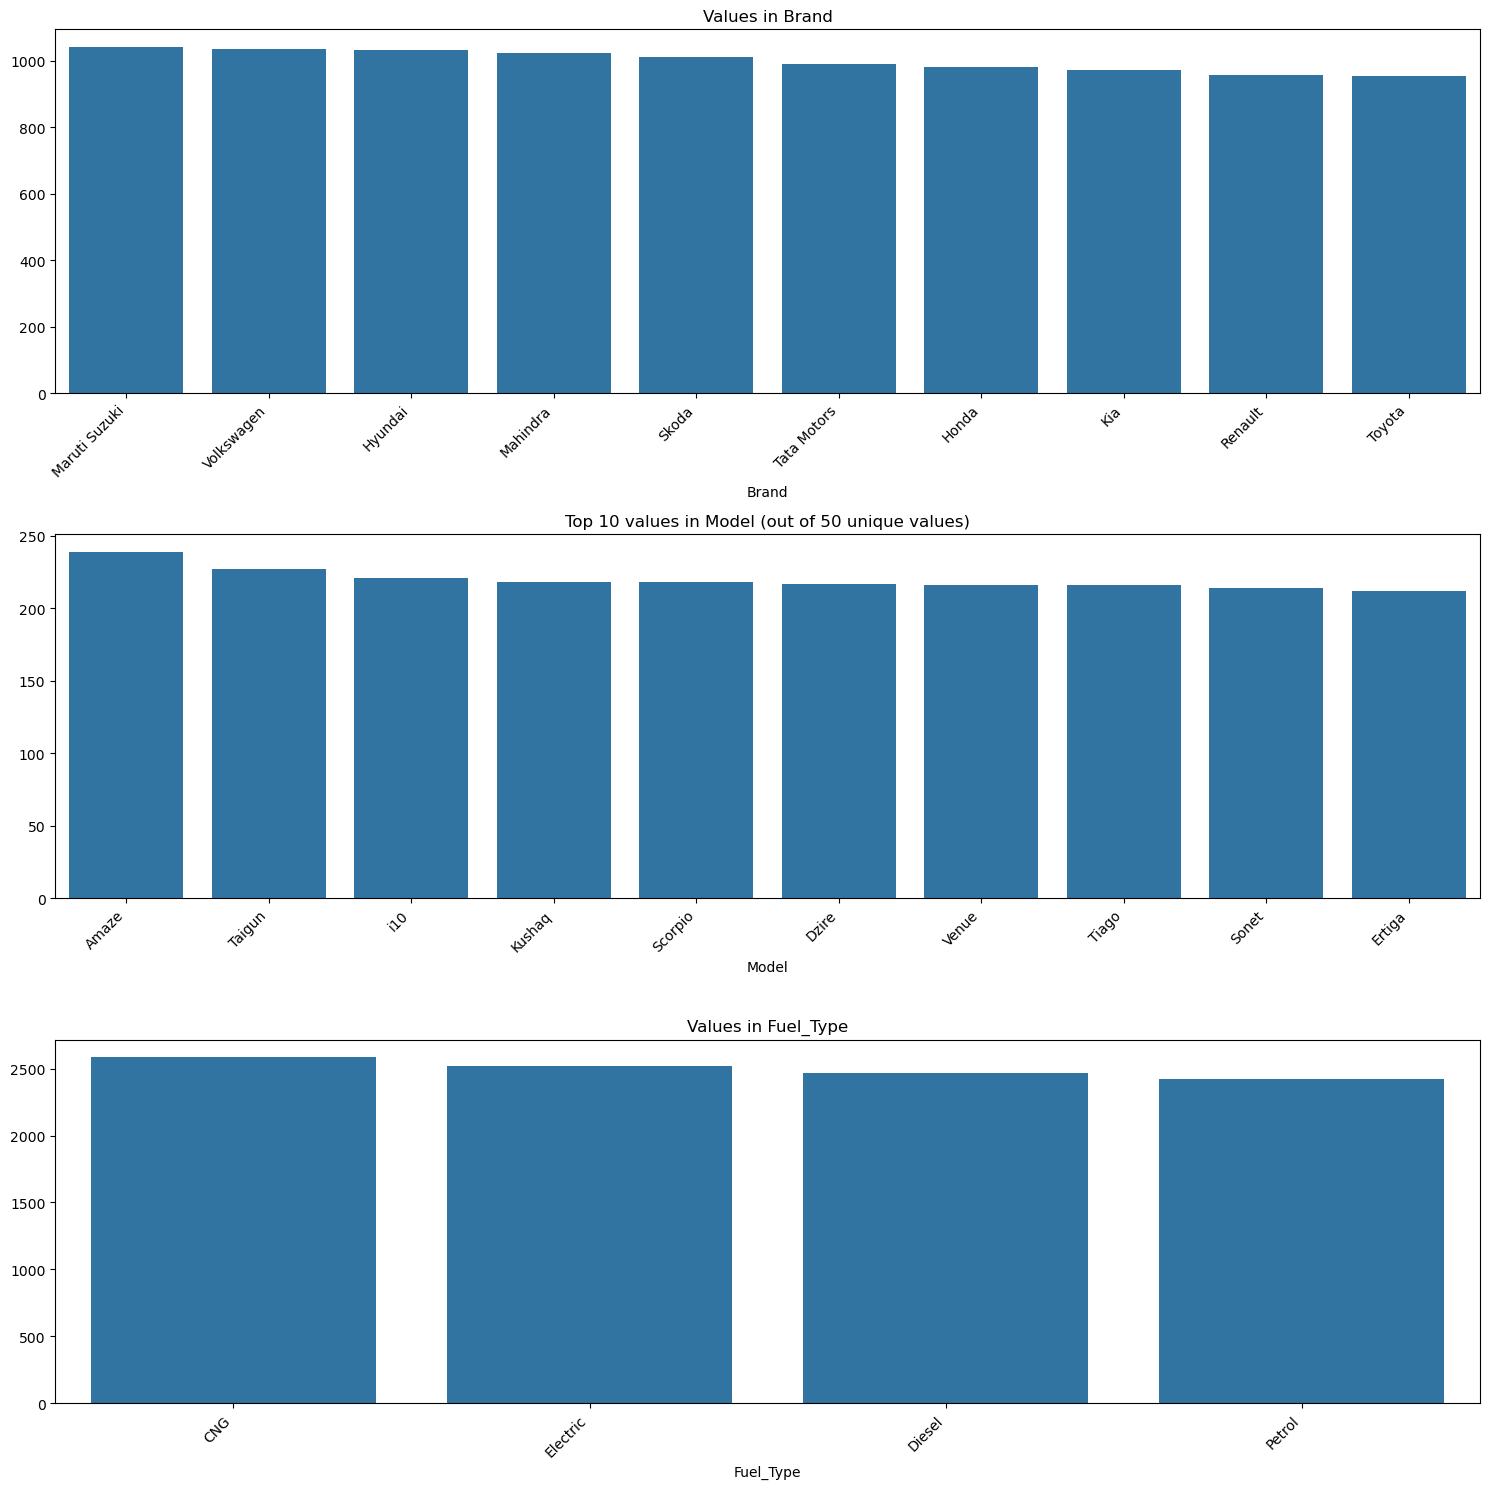


Generating GPT-4o-mini Analysis...


# Comprehensive Summary

The dataset contains information on 10,000 cars, characterized by 11 columns that encompass various attributes such as Car_ID, Brand, Model, Year, Fuel_Type, Transmission, Price, Mileage, Engine_CC, Seating_Capacity, and Service_Cost. The data spans a range of years from 2015 to 2024, indicating a relatively recent collection of vehicles. The average price of the cars is approximately 1,946,064.00, with a significant range from 400,000.00 to 3,500,000.00, suggesting a diverse market segment that includes both budget-friendly and premium vehicles.

In terms of fuel types, the dataset includes CNG, Electric, Diesel, and Petrol, with CNG being the most common fuel type represented. The average mileage of the cars is around 19.97 km/l, with a range from 10.00 to 30.00 km/l, indicating varied fuel efficiency across different models. The average engine capacity is 1542.07 cc, with a maximum of 2500 cc, which aligns with the typical specifications for modern vehicles. The average seating capacity is 5.52, indicating that most cars are designed to accommodate families or small groups.

The dataset also reveals that the majority of cars have a manual transmission (5045) compared to automatic (4955), reflecting consumer preferences in the market. The service costs range from 5,000.00 to 25,000.00, with an average of 14,969.13, which could be a crucial factor for potential buyers when considering long-term ownership costs. The data shows a balanced distribution across various brands and models, providing a comprehensive overview of the automotive landscape within the specified timeframe.

# Key Insights and Findings

- **Price Distribution**: The average price indicates a wide range of vehicle types, catering to different economic segments. The high standard deviation (883,794.51) suggests that there are significant price variations among the models.
- **Fuel Type Popularity**: CNG vehicles are the most common, followed closely by Electric and Diesel, which may reflect current trends towards more sustainable fuel options.
- **Transmission Preference**: The slight preference for manual transmission may indicate consumer behavior trends, possibly influenced by driving experiences or cost considerations.
- **Mileage and Engine Capacity**: The average mileage of 19.97 km/l suggests a focus on fuel efficiency, while the engine capacity indicates a balance between performance and economy.

# Data Quality Issues or Limitations

- **Missing Values**: The summary does not indicate whether there are any missing values in the dataset. If present, these could skew the analysis and insights drawn from the data.
- **Outliers**: The wide range in price and service costs suggests potential outliers that may need to be addressed to ensure a more accurate analysis.
- **Categorical Data**: The dataset contains categorical variables (Brand, Model, Fuel_Type, Transmission) that may require encoding for certain types of analyses, which could complicate the analysis process.
- **Temporal Relevance**: The dataset covers a limited timeframe (2015-2024), which may not capture long-term trends in the automotive market.

# Recommendations for Further Analysis

- **Exploratory Data Analysis (EDA)**: Conduct a thorough EDA to visualize distributions, detect outliers, and identify relationships between variables, particularly focusing on price, mileage, and engine capacity.
- **Correlation Analysis**: Investigate correlations between numerical variables to understand how factors like engine capacity and mileage affect price.
- **Time Series Analysis**: Analyze trends over the years to assess how car prices and preferences for fuel types and transmissions have evolved.
- **Segmentation Analysis**: Segment the data by brand, fuel type, and transmission to identify specific market trends and consumer preferences within different demographics.
- **Predictive Modeling**: Develop predictive models to forecast car prices based on various features, which could be valuable for stakeholders in the automotive industry.

In [8]:
# Initialize the summarizer
summarizer = CSVSummarizer()

# Basic usage
df, summary = summarizer.analyze_csv('car_dataset_india.csv')

# With custom CSV parameters
# df, summary = summarizer.analyze_csv('your_data.csv', 
#                                     sep=';',  # Use semicolon as separator
#                                     encoding='latin1',  # Specific encoding
#                                     focus='customer behavior')  # Analysis focus